# Análisis de Arbitraje en Acciones Españolas - Pipeline Completo

## Misión

Este notebook responde a tres preguntas críticas:

1. **¿Existen aún oportunidades de arbitraje en acciones españolas?**
2. **¿Cuál es el profit teórico máximo (asumiendo latencia 0)?**
3. **¿Qué tan rápido desaparece este profit cuando el sistema de trading se vuelve más lento (de 0µs a 100ms)?**

---

## (WARNING) IMPORTANTE: Arquitectura Modular

Este notebook integra el código Python modular (`src/*.py`) para realizar el análisis completo de arbitraje.

**Características:**
- Las funciones se importan desde módulos modulares
- La configuración se carga desde `config_module`
- Pipeline completo de análisis de arbitraje

---

## Índice

1. [Configuración e Imports](#configuracion)
2. [Descubrimiento de ISINs](#descubrimiento)
3. [Loop Principal de Análisis](#loop-principal)
4. [Deliverable 1: Money Table](#money-table)
5. [Deliverable 2: Decay Chart](#decay-chart)
6. [Deliverable 3: Top Opportunities](#top-opportunities)
7. [Resumen y Respuestas Clave](#resumen)

---

## Flujo del Pipeline

```
┌─────────────────────────────────────────────────────────────┐
│  PASO 1: CARGA DE DATOS                                     │
│  ─────────────────────────────────────────────────────────── │
│  • Leer archivos QTE (quotes) y STS (status)                │
│  • Validar estructura de datos                             │
└────────────────────┬────────────────────────────────────────┘
                     │
┌────────────────────▼────────────────────────────────────────┐
│  PASO 2: FILTRADO Y LIMPIEZA                                │
│  ─────────────────────────────────────────────────────────── │
│  • Eliminar magic numbers (precios inválidos)               │
│  • Filtrar por continuous trading                           │
│  • Validar precios (bid > 0, ask > 0, bid < ask)            │
└────────────────────┬────────────────────────────────────────┘
                     │
┌────────────────────▼────────────────────────────────────────┐
│  PASO 3: CONSOLIDACIÓN                                      │
│  ─────────────────────────────────────────────────────────── │
│  • Crear consolidated tape único                            │
│  • Merge de todos los exchanges por epoch                   │
│  • Forward fill de precios                                  │
└────────────────────┬────────────────────────────────────────┘
                     │
┌────────────────────▼────────────────────────────────────────┐
│  PASO 4: DETECCIÓN DE ARBITRAJE                             │
│  ─────────────────────────────────────────────────────────── │
│  • Calcular MAX(bid) y MIN(ask) globales                   │
│  • Identificar oportunidades (MAX(bid) > MIN(ask))          │
└────────────────────┬────────────────────────────────────────┘
                     │
┌────────────────────▼────────────────────────────────────────┐
│  PASO 5: RISING EDGE DETECTION                              │
│  ─────────────────────────────────────────────────────────── │
│  • Aplicar filtro de liquidez independiente                │
│  • Contar solo oportunidades únicas                        │
└────────────────────┬────────────────────────────────────────┘
                     │
┌────────────────────▼────────────────────────────────────────┐
│  PASO 6: SIMULACIÓN DE LATENCIA                             │
│  ─────────────────────────────────────────────────────────── │
│  • Simular profit/loss para cada nivel de latencia          │
│  • Calcular profit realizable en T + Latency                │
└────────────────────┬────────────────────────────────────────┘
                     │
┌────────────────────▼────────────────────────────────────────┐
│  PASO 7: ANÁLISIS Y REPORTES                                │
│  ─────────────────────────────────────────────────────────── │
│  • Money Table (profit por ISIN y latencia)                 │
│  • Decay Chart (gráfico de decay)                           │
│  • Top Opportunities (ISINs más rentables)                 │
│  • Resumen y respuestas clave                               │
└─────────────────────────────────────────────────────────────┘
```


## Configuración e Imports de Módulos {#configuracion}

En esta sección:
- Importamos todas las librerías necesarias
- Configuramos los paths y parámetros
- Importamos las funciones desde los módulos Python
- Establecemos las variables de configuración


In [8]:
# ============================================================================
# CONFIGURACIÓN E IMPORTS DE MÓDULOS
# ============================================================================
# Importa todas las funciones necesarias desde los módulos Python modulares

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from typing import Dict, List, Tuple, Optional
from collections import defaultdict
import sys
import importlib
import warnings
warnings.filterwarnings('ignore')

# Configurar encoding UTF-8 para Windows
if sys.platform == 'win32':
    try:
        sys.stdout.reconfigure(encoding='utf-8')
    except:
        pass

# Agregar directorio src al path para imports de módulos
PROJECT_ROOT = Path.cwd()
sys.path.insert(0, str(PROJECT_ROOT / 'src'))

print("="*80)
print("CONFIGURACIÓN INICIAL")
print("="*80)
print(f"Directorio del proyecto: {PROJECT_ROOT}")

# Recargar módulos para evitar problemas de caché del kernel
if 'data_loader_module' in sys.modules:
    importlib.reload(sys.modules['data_loader_module'])
    print("[INFO] Módulo data_loader_module recargado")

# Importar configuración desde el módulo
from config_module import config

# Importar todas las funciones desde los módulos
# Funciones de carga de datos
from data_loader_module import (
    is_valid_price,
    load_qte_file,
    load_sts_file,
    filter_valid_prices,
    filter_continuous_trading,
    load_data_for_isin,
    find_all_isins
)

# Funciones de consolidated tape
from consolidator_module import (
    create_consolidated_tape,
    get_quote_at_epoch
)

# Funciones de detección de arbitraje
from signal_generator_module import (
    detect_arbitrage_opportunities,
    apply_rising_edge_detection
)

# Función de simulación de latencia
from latency_simulator_module import simulate_latency_with_losses

# Funciones de análisis y reportes
from analyzer_module import (
    create_money_table,
    create_decay_chart,
    identify_top_opportunities,
    generate_summary_answers
)

print("[OK] Todos los módulos importados correctamente")

# ============================================================================
# VARIABLES DE CONFIGURACIÓN
# ============================================================================
# Configuración del análisis

# Ruta de datos - puede cambiarse aquí
# Para pruebas rápidas: usar config.DATA_SMALL_DIR
# Para análisis completo: usar config.DATA_BIG_DIR
DATA_PATH = str(config.DATA_SMALL_DIR)  # Cambiar a config.DATA_SMALL_DIR para testing rápido
DATE = "2025-11-07"

# Usar configuración del módulo
EXCHANGES = config.EXCHANGES
CONTINUOUS_TRADING_STATUS = config.CONTINUOUS_TRADING_STATUS
MAGIC_NUMBERS = config.MAGIC_NUMBERS
LATENCY_LEVELS = config.LATENCY_LEVELS

print("\n" + "="*80)
print("CONFIGURACIÓN CARGADA")
print("="*80)
print(f"(INFO) Ruta de datos: {DATA_PATH}")
print(f"(INFO) Fecha: {DATE}")
print(f"(INFO) Exchanges: {EXCHANGES}")
print(f"(INFO) Magic numbers: {len(MAGIC_NUMBERS)} valores")
print(f"(INFO) Niveles de latencia: {len(LATENCY_LEVELS)} niveles")
print(f"(INFO) Latencias: {[f'{lat/1000:.1f}ms' if lat > 0 else '0ms' for lat in LATENCY_LEVELS[:5]]} ... {LATENCY_LEVELS[-1]/1000:.0f}ms")
print("\n(OK) Configuración completada exitosamente!")


CONFIGURACIÓN INICIAL
Directorio del proyecto: c:\Users\Usuario\Downloads\TAREA_RENTA_VARIABLE
[INFO] Módulo data_loader_module recargado
[OK] Todos los módulos importados correctamente

CONFIGURACIÓN CARGADA
(INFO) Ruta de datos: c:\Users\Usuario\Downloads\TAREA_RENTA_VARIABLE\data\DATA_SMALL
(INFO) Fecha: 2025-11-07
(INFO) Exchanges: ['BME', 'AQUIS', 'CBOE', 'TURQUOISE']
(INFO) Magic numbers: 6 valores
(INFO) Niveles de latencia: 14 niveles
(INFO) Latencias: ['0ms', '0.1ms', '0.5ms', '1.0ms', '2.0ms'] ... 100ms

(OK) Configuración completada exitosamente!


## Descubrimiento de ISINs {#descubrimiento}

En este paso descubrimos todos los ISINs únicos disponibles en los datos.


In [9]:
# ============================================================================
# DESCUBRIMIENTO DE ISINs
# ============================================================================
# Buscamos todos los ISINs únicos disponibles en los datos

print("="*80)
print("DESCUBRIENDO ISINs DISPONIBLES")
print("="*80)

all_isins = find_all_isins(DATA_PATH, DATE)

print(f"(OK) Encontrados {len(all_isins)} ISINs únicos")
if len(all_isins) > 0:
    print(f"(INFO) Primeros 10: {all_isins[:10]}")
    if len(all_isins) > 10:
        print(f"(INFO) ... y {len(all_isins) - 10} más")

# Crear tabla de resumen
if len(all_isins) > 0:
    isin_summary = pd.DataFrame({
        'Total ISINs': [len(all_isins)],
        'Dataset': [Path(DATA_PATH).name],
        'Fecha': [DATE]
    })
    print("\n" + "="*80)
    print("RESUMEN DE ISINs")
    print("="*80)
    print(isin_summary.to_string(index=False))


DESCUBRIENDO ISINs DISPONIBLES
(OK) Encontrados 1 ISINs únicos
(INFO) Primeros 10: ['ES0113900J37']

RESUMEN DE ISINs
 Total ISINs    Dataset      Fecha
           1 DATA_SMALL 2025-11-07


## Loop Principal de Análisis {#loop-principal}

En esta sección procesamos cada ISIN siguiendo el flujo completo del pipeline:

1. **Carga de datos**: Cargar QTE y STS para el ISIN
2. **Filtrado y Limpieza**: Eliminar magic numbers y filtrar por continuous trading
3. **Consolidación**: Crear consolidated tape único
4. **Detección**: Identificar oportunidades de arbitraje
5. **Rising Edge**: Aplicar filtro de liquidez independiente
6. **Simulación**: Calcular profit/loss para cada nivel de latencia



INICIANDO ANÁLISIS DE TODOS LOS ISINs
(INFO) Total de ISINs a procesar: 1
(INFO) Niveles de latencia: 14


[1/1] PROCESANDO ISIN: ES0113900J37

PASO 1: CARGA DE DATOS - ISIN: ES0113900J37
(OK) Datos encontrados de 4 exchange(s): ['BME', 'AQUIS', 'CBOE', 'TURQUOISE']

(INFO) Estadísticas de carga por exchange:
 Exchange  Snapshots QTE  Snapshots STS             Epoch Min             Epoch Max
      BME         362896              7 1,762,502,419,350,780 1,762,533,000,577,049
    AQUIS         101559              6 1,762,502,416,697,531 1,762,532,999,612,399
     CBOE          78375              7 1,762,502,419,076,794 1,762,532,999,418,408
TURQUOISE          43316              3 1,762,502,416,697,156 1,762,533,001,057,722

PASO 2: FILTRADO Y LIMPIEZA - ISIN: ES0113900J37

(INFO) Estadísticas de filtrado por exchange:
 Exchange  Snapshots Válidos               Estado
      BME             362896 (OK) Datos filtrados
    AQUIS             101559 (OK) Datos filtrados
     CBOE            

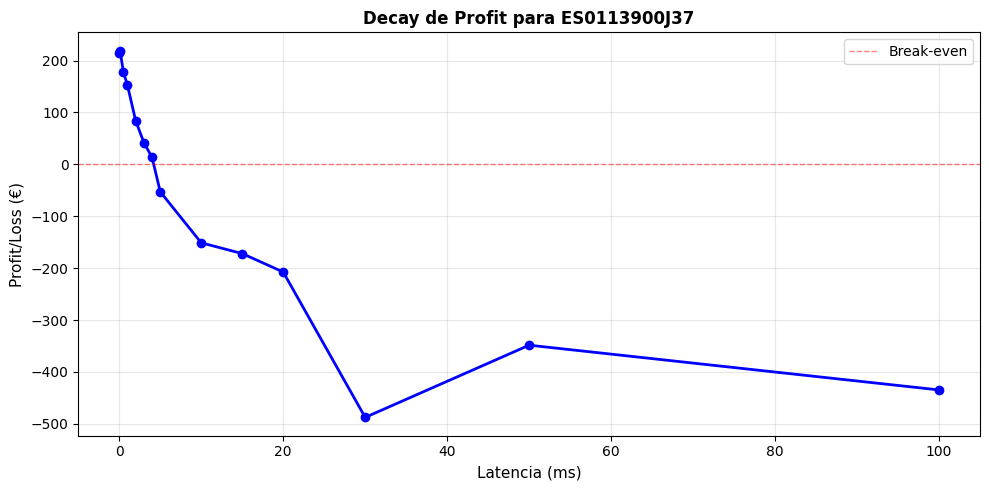


(OK) ISIN ES0113900J37 procesado exitosamente


ANÁLISIS COMPLETADO

(INFO) Resumen del Análisis:
 Total ISINs Procesados  ISINs con Datos  ISINs con Consolidated Tape  ISINs con Oportunidades  ISINs con Rising Edge  Total Oportunidades  Oportunidades Válidas
                      1                1                            1                        1                      1                 4054                    348



In [10]:
# ============================================================================
# LOOP PRINCIPAL DE ANÁLISIS
# ============================================================================
# Procesa cada ISIN siguiendo el pipeline completo de análisis

# Almacenamiento para resultados
money_table_data = []

# Estadísticas globales para visualización
stats_summary = {
    'total_isins_processed': 0,
    'isins_with_data': 0,
    'isins_with_consolidated': 0,
    'isins_with_opportunities': 0,
    'isins_with_rising_edge': 0,
    'total_opportunities': 0,
    'total_rising_edge_opportunities': 0
}

print("\n" + "="*80)
print("INICIANDO ANÁLISIS DE TODOS LOS ISINs")
print("="*80)
print(f"(INFO) Total de ISINs a procesar: {len(all_isins)}")
print(f"(INFO) Niveles de latencia: {len(LATENCY_LEVELS)}")
print("="*80 + "\n")

# Procesar cada ISIN
for isin_idx, isin in enumerate(all_isins, 1):
    print(f"\n{'='*80}")
    print(f"[{isin_idx}/{len(all_isins)}] PROCESANDO ISIN: {isin}")
    print(f"{'='*80}")
    
    stats_summary['total_isins_processed'] += 1
    
    # ========================================================================
    # PASO 1: CARGA DE DATOS
    # ========================================================================
    print("\n" + "="*80)
    print(f"PASO 1: CARGA DE DATOS - ISIN: {isin}")
    print("="*80)
    data_dict = load_data_for_isin(DATA_PATH, DATE, isin)
    
    if not data_dict:
        print(f"(WARNING) No se encontraron datos para {isin}")
        continue
    
    stats_summary['isins_with_data'] += 1
    exchanges_found = list(data_dict.keys())
    print(f"(OK) Datos encontrados de {len(exchanges_found)} exchange(s): {exchanges_found}")
    
    # Mostrar estadísticas de carga por exchange
    load_stats = []
    for exchange, (qte_df, sts_df) in data_dict.items():
        load_stats.append({
            'Exchange': exchange,
            'Snapshots QTE': len(qte_df),
            'Snapshots STS': len(sts_df),
            'Epoch Min': f"{qte_df['epoch'].min():,}" if not qte_df.empty else "N/A",
            'Epoch Max': f"{qte_df['epoch'].max():,}" if not qte_df.empty else "N/A"
        })
    
    if load_stats:
        load_df = pd.DataFrame(load_stats)
        print("\n(INFO) Estadísticas de carga por exchange:")
        print(load_df.to_string(index=False))
    
    # ========================================================================
    # PASO 2: FILTRADO Y LIMPIEZA
    # ========================================================================
    print("\n" + "="*80)
    print(f"PASO 2: FILTRADO Y LIMPIEZA - ISIN: {isin}")
    print("="*80)
    
    # El filtrado ya se aplica dentro de load_data_for_isin, pero mostramos estadísticas
    filtered_stats = []
    total_before = 0
    total_after = 0
    
    for exchange, (qte_df, sts_df) in data_dict.items():
        # Contar snapshots después del filtrado (ya filtrados en load_data_for_isin)
        after_count = len(qte_df)
        total_after += after_count
        
        filtered_stats.append({
            'Exchange': exchange,
            'Snapshots Válidos': after_count,
            'Estado': '(OK) Datos filtrados' if after_count > 0 else '(WARNING) Sin datos válidos'
        })
    
    if filtered_stats:
        filtered_df = pd.DataFrame(filtered_stats)
        print("\n(INFO) Estadísticas de filtrado por exchange:")
        print(filtered_df.to_string(index=False))
        print(f"\n(INFO) Total snapshots válidos después de filtrado: {total_after:,}")
        print("(INFO) Filtros aplicados:")
        print("  - Magic numbers eliminados")
        print("  - Solo continuous trading")
        print("  - Precios válidos (bid > 0, ask > 0, bid < ask)")
    
    # ========================================================================
    # PASO 3: CONSOLIDACIÓN
    # ========================================================================
    print("\n" + "="*80)
    print(f"PASO 3: CONSOLIDACIÓN - ISIN: {isin}")
    print("="*80)
    consolidated = create_consolidated_tape(data_dict)
    
    if consolidated.empty:
        print(f"(WARNING) No se pudo crear consolidated tape para {isin}")
        continue
    
    stats_summary['isins_with_consolidated'] += 1
    print(f"(OK) Consolidated tape creado: {len(consolidated):,} snapshots")
    print(f"(INFO) Columnas: {len(consolidated.columns)} columnas")
    print(f"(INFO) Rango temporal: {consolidated.index.min():,} - {consolidated.index.max():,} µs")
    
    # Mostrar columnas disponibles
    bid_cols = [col for col in consolidated.columns if '_bid' in col]
    ask_cols = [col for col in consolidated.columns if '_ask' in col]
    print(f"(INFO) Exchanges en tape: {len(bid_cols)} exchanges")
    print(f"(INFO) Bids: {bid_cols}")
    print(f"(INFO) Asks: {ask_cols}")
    
    # ========================================================================
    # PASO 4: DETECCIÓN DE ARBITRAJE
    # ========================================================================
    print("\n" + "="*80)
    print(f"PASO 4: DETECCIÓN DE ARBITRAJE - ISIN: {isin}")
    print("="*80)
    opportunities = detect_arbitrage_opportunities(consolidated)
    
    if opportunities.empty:
        print(f"(WARNING) No se encontraron oportunidades de arbitraje para {isin}")
        continue
    
    stats_summary['isins_with_opportunities'] += 1
    stats_summary['total_opportunities'] += len(opportunities)
    print(f"(OK) Oportunidades detectadas: {len(opportunities):,}")
    
    # Mostrar estadísticas de oportunidades
    if len(opportunities) > 0:
        opp_stats = {
            'Total Oportunidades': len(opportunities),
            'Profit Promedio/Share': f"€{opportunities['profit_per_share'].mean():.4f}",
            'Profit Máximo/Share': f"€{opportunities['profit_per_share'].max():.4f}",
            'Cantidad Promedio': f"{opportunities['tradeable_qty'].mean():.0f}",
            'Profit Total Teórico': f"€{opportunities['total_profit'].sum():,.2f}"
        }
        opp_df = pd.DataFrame([opp_stats])
        print("\n(INFO) Estadísticas de oportunidades:")
        print(opp_df.to_string(index=False))
    
    # ========================================================================
    # PASO 5: RISING EDGE DETECTION (Filtro de Liquidez)
    # ========================================================================
    print("\n" + "="*80)
    print(f"PASO 5: RISING EDGE DETECTION - ISIN: {isin}")
    print("="*80)
    opportunities_filtered = apply_rising_edge_detection(opportunities)
    
    if opportunities_filtered.empty:
        print(f"(WARNING) No quedaron oportunidades después del filtro de liquidez para {isin}")
        continue
    
    stats_summary['isins_with_rising_edge'] += 1
    stats_summary['total_rising_edge_opportunities'] += len(opportunities_filtered)
    
    reduction_pct = ((len(opportunities) - len(opportunities_filtered)) / len(opportunities) * 100) if len(opportunities) > 0 else 0
    print(f"(OK) Oportunidades después de Rising Edge: {len(opportunities_filtered):,}")
    print(f"(INFO) Reducción: {reduction_pct:.1f}% ({len(opportunities):,} → {len(opportunities_filtered):,})")
    
    # Mostrar estadísticas después del filtro
    if len(opportunities_filtered) > 0:
        filtered_stats = {
            'Oportunidades Válidas': len(opportunities_filtered),
            'Profit Promedio/Share': f"€{opportunities_filtered['profit_per_share'].mean():.4f}",
            'Profit Máximo/Share': f"€{opportunities_filtered['profit_per_share'].max():.4f}",
            'Cantidad Promedio': f"{opportunities_filtered['tradeable_qty'].mean():.0f}",
            'Profit Total Válido': f"€{opportunities_filtered['total_profit'].sum():,.2f}"
        }
        filtered_df = pd.DataFrame([filtered_stats])
        print("\n(INFO) Estadísticas después del filtro:")
        print(filtered_df.to_string(index=False))
    
    # ========================================================================
    # PASO 6: SIMULACIÓN DE LATENCIA
    # ========================================================================
    print("\n" + "="*80)
    print(f"PASO 6: SIMULACIÓN DE LATENCIA - ISIN: {isin}")
    print("="*80)
    profits_by_latency = {}
    
    for latency_us in LATENCY_LEVELS:
        profit = simulate_latency_with_losses(opportunities_filtered, consolidated, latency_us)
        profits_by_latency[latency_us] = profit
        
        money_table_data.append({
            'ISIN': isin,
            'Latency_us': latency_us,
            'Profit_EUR': profit
        })
    
    # Mostrar tabla de profits por latencia
    print(f"\n(INFO) Profit/Loss por Latencia para {isin}:")
    print(f"{'Latencia (µs)':<15} {'Latencia (ms)':<15} {'Profit/Loss (€)':<20} {'% de 0 latencia':<15} {'Estado':<10}")
    print(f"{'-'*80}")
    
    zero_latency_profit = profits_by_latency[0]
    latency_results = []
    
    for latency_us in LATENCY_LEVELS:
        profit = profits_by_latency[latency_us]
        latency_ms = latency_us / 1000
        if zero_latency_profit != 0:
            pct = (profit / zero_latency_profit * 100) if zero_latency_profit != 0 else 0
            pct_str = f"{pct:.1f}%"
        else:
            pct_str = "N/A"
        
        # Estado: positivo = ganancia, negativo = pérdida, cero = neutral
        profit_str = f"€{profit:,.2f}"
        if profit > 0:
            status = "(OK)"
        elif profit < 0:
            status = "(LOSS)"
        else:
            status = "(NEUTRAL)"
        
        print(f"{latency_us:<15} {latency_ms:<15.3f} {profit_str:<20} {pct_str:<15} {status}")
        
        latency_results.append({
            'Latencia (ms)': latency_ms,
            'Profit/Loss (€)': profit,
            '% de 0 latencia': pct if zero_latency_profit != 0 else 0
        })
    
    print(f"{'-'*80}")
    print(f"(INFO) Profit total a latencia 0: €{zero_latency_profit:,.2f}")
    
    # Crear gráfico simple de decay para este ISIN
    if zero_latency_profit > 0:
        latency_df = pd.DataFrame(latency_results)
        fig, ax = plt.subplots(figsize=(10, 5))
        ax.plot(latency_df['Latencia (ms)'], latency_df['Profit/Loss (€)'], 'b-o', linewidth=2, markersize=6)
        ax.axhline(y=0, color='r', linestyle='--', linewidth=1, alpha=0.5, label='Break-even')
        ax.set_xlabel('Latencia (ms)', fontsize=11)
        ax.set_ylabel('Profit/Loss (€)', fontsize=11)
        ax.set_title(f'Decay de Profit para {isin}', fontsize=12, fontweight='bold')
        ax.grid(True, alpha=0.3)
        ax.legend()
        plt.tight_layout()
        plt.show()
    
    print(f"\n(OK) ISIN {isin} procesado exitosamente\n")

# ========================================================================
# RESUMEN FINAL DEL ANÁLISIS
# ========================================================================
print("\n" + "="*80)
print("ANÁLISIS COMPLETADO")
print("="*80)

summary_df = pd.DataFrame([{
    'Total ISINs Procesados': stats_summary['total_isins_processed'],
    'ISINs con Datos': stats_summary['isins_with_data'],
    'ISINs con Consolidated Tape': stats_summary['isins_with_consolidated'],
    'ISINs con Oportunidades': stats_summary['isins_with_opportunities'],
    'ISINs con Rising Edge': stats_summary['isins_with_rising_edge'],
    'Total Oportunidades': stats_summary['total_opportunities'],
    'Oportunidades Válidas': stats_summary['total_rising_edge_opportunities']
}])

print("\n(INFO) Resumen del Análisis:")
print(summary_df.to_string(index=False))
print("\n" + "="*80)


## Deliverable 1: La "Money Table" {#money-table}

Tabla pivot que muestra el profit total realizado por cada ISIN para cada nivel de latencia.

Esta tabla es el resultado principal del análisis y muestra:
- Profit por ISIN y latencia
- Resumen agregado por latencia
- Direcciones de exchange más comunes


In [11]:
# ============================================================================
# DELIVERABLE 1: LA "MONEY TABLE"
# ============================================================================
# Genera la tabla pivot con profit por ISIN y latencia usando analyzer_module

print("="*80)
print("GENERANDO MONEY TABLE")
print("="*80)

# Crear la tabla pivot usando la función del módulo
pivot, summary_df = create_money_table(money_table_data)

# Contar oportunidades de arbitraje por dirección de exchange (Buy -> Sell)
# Esta sección se mantiene inline porque requiere DATA_PATH y DATE
if money_table_data:
    money_df = pd.DataFrame(money_table_data)
    
    print("\n" + "="*80)
    print("OPORTUNIDADES DE ARBITRAJE POR DIRECCIÓN DE EXCHANGE")
    print("="*80)
    
    # Obtener ISINs con oportunidades a latencia 0
    isins_with_opps = money_df[(money_df['Latency_us'] == 0) & (money_df['Profit_EUR'] > 0)]['ISIN'].unique()
    
    print(f"(INFO) Analizando {len(isins_with_opps)} ISINs con oportunidades...")
    
    # Contar oportunidades por dirección de exchange (Buy Exchange -> Sell Exchange)
    exchange_direction_counts = defaultdict(int)
    
    for isin_idx, isin in enumerate(isins_with_opps, 1):
        if isin_idx % 10 == 0:
            print(f"   Procesando ISIN {isin_idx}/{len(isins_with_opps)}...")
        
        # Cargar datos para este ISIN (usando función del módulo)
        data_dict = load_data_for_isin(DATA_PATH, DATE, isin)
        
        if not data_dict:
            continue
        
        # Crear consolidated tape (usando función del módulo)
        consolidated = create_consolidated_tape(data_dict)
        
        if consolidated.empty:
            continue
        
        # Detectar oportunidades de arbitraje (usando función del módulo)
        opportunities = detect_arbitrage_opportunities(consolidated)
        
        if opportunities.empty:
            continue
        
        # Aplicar rising edge detection (usando función del módulo)
        opportunities = apply_rising_edge_detection(opportunities)
        
        if opportunities.empty:
            continue
        
        # Contar por dirección de exchange (Buy -> Sell)
        for _, opp in opportunities.iterrows():
            buy_ex = opp.get('buy_exchange', '')
            sell_ex = opp.get('sell_exchange', '')
            
            if buy_ex and sell_ex:
                # Contar dirección por separado (Buy -> Sell)
                direction = f"{buy_ex} → {sell_ex}"
                exchange_direction_counts[direction] += 1
    
    # Ordenar por conteo (descendente)
    sorted_directions = sorted(exchange_direction_counts.items(), key=lambda x: x[1], reverse=True)
    
    if sorted_directions:
        print(f"\n{'Rank':<8} {'Dirección Exchange (Buy → Sell)':<40} {'Oportunidades':<15}")
        print(f"{'-'*8} {'-'*40} {'-'*15}")
        
        for rank, (direction, count) in enumerate(sorted_directions, 1):
            print(f"{rank:<8} {direction:<40} {count:<15}")
        
        # Crear tabla para visualización
        direction_df = pd.DataFrame(sorted_directions, columns=['Dirección', 'Oportunidades'])
        direction_df['Rank'] = range(1, len(direction_df) + 1)
        direction_df = direction_df[['Rank', 'Dirección', 'Oportunidades']]
        
        print(f"\n(INFO) Resumen:")
        print(f"(INFO) Total direcciones únicas: {len(sorted_directions)}")
        print(f"(INFO) Total oportunidades: {sum(exchange_direction_counts.values()):,}")
        
        # Mostrar top 10 en tabla
        if len(direction_df) > 10:
            print(f"\n(INFO) Top 10 direcciones más comunes:")
            print(direction_df.head(10).to_string(index=False))
        else:
            print(f"\n(INFO) Todas las direcciones:")
            print(direction_df.to_string(index=False))
    else:
        print("(WARNING) No hay datos de dirección de exchange disponibles.")


GENERANDO MONEY TABLE
MONEY TABLE: Total Realized Profit/Loss by ISIN and Latency
Latency_us     0        100      500      1000    2000    3000    4000    5000     10000    15000    20000    30000    50000    100000
ISIN                                                                                                                                  
ES0113900J37  215.488  219.156  178.221  152.451  84.185  42.065  13.413 -52.799 -151.153 -171.909 -207.445 -487.618 -348.459 -434.722
TOTAL         215.488  219.156  178.221  152.451  84.185  42.065  13.413 -52.799 -151.153 -171.909 -207.445 -487.618 -348.459 -434.722

SUMMARY BY LATENCY (All ISINs Combined)
 Latency (µs)  Total Profit/Loss (€)  Latency (ms)  % of 0 latency
            0                215.488           0.0      100.000000
          100                219.156           0.1      101.702183
          500                178.221           0.5       82.705766
         1000                152.451           1.0       70.746863
  

## Deliverable 2: El Decay Chart {#decay-chart}

Gráfico que muestra cómo decae el profit total a medida que aumenta la latencia.

Incluye:
- Gráfico lineal o logarítmico según corresponda
- Gráfico de porcentaje respecto a latencia 0
- Análisis de decay en puntos clave (1ms, 10ms, 100ms)


GENERANDO DECAY CHART

  Gráfico guardado en: c:\Users\Usuario\Downloads\TAREA_RENTA_VARIABLE\output\figures\decay_chart.png


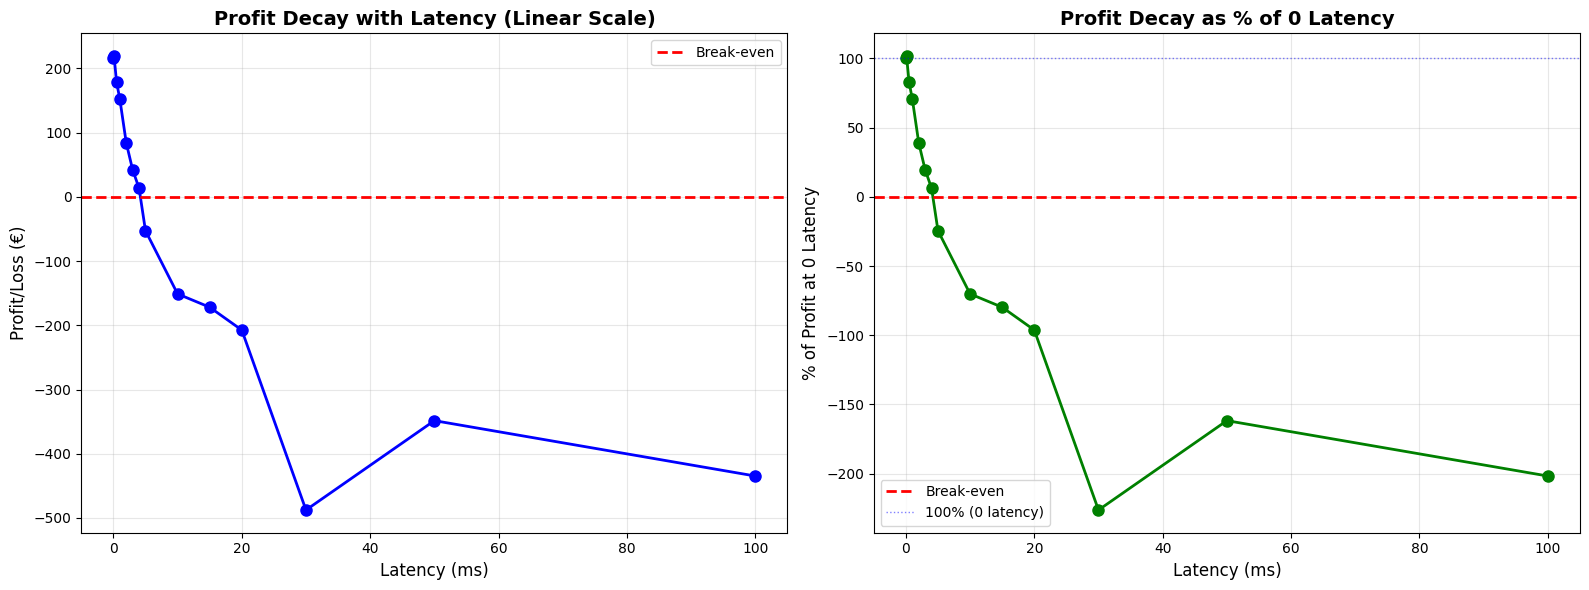


Decay Analysis:
  Maximum profit (0 latency): €215.49
  Profit/Loss at 1.0ms: €152.45
  Profit/Loss at 10.0ms: €-151.15
  Profit/Loss at 100.0ms: €-434.72


In [12]:
# ============================================================================
# DELIVERABLE 2: EL DECAY CHART
# ============================================================================
# Genera el gráfico de decay de profit con latencia usando analyzer_module

print("="*80)
print("GENERANDO DECAY CHART")
print("="*80)

# Crear el gráfico de decay usando la función del módulo
create_decay_chart(money_table_data, save_path=str(config.FIGURES_DIR / 'decay_chart.png'))


## Deliverable 3: Top Opportunities {#top-opportunities}

Identifica los 5 ISINs más rentables con información detallada de cada uno:

- Profit total teórico
- Número de oportunidades
- Profit promedio y máximo por oportunidad
- Mejor oportunidad individual
- Sanity checks (verificación de razonabilidad)


In [13]:
# ============================================================================
# DELIVERABLE 3: TOP OPPORTUNITIES
# ============================================================================
# Identifica los ISINs más rentables usando analyzer_module

print("="*80)
print("IDENTIFICANDO TOP OPPORTUNITIES")
print("="*80)

# Identificar las top 5 oportunidades usando la función del módulo
top_opportunities_df = identify_top_opportunities(money_table_data, DATA_PATH, DATE, n=5)

# Mostrar tabla resumen si hay datos
if not top_opportunities_df.empty:
    print("\n" + "="*80)
    print("TABLA RESUMEN DE TOP OPPORTUNITIES")
    print("="*80)
    summary_cols = ['rank', 'isin', 'total_profit', 'num_opportunities', 'avg_profit', 'max_profit']
    available_cols = [col for col in summary_cols if col in top_opportunities_df.columns]
    if available_cols:
        print(top_opportunities_df[available_cols].to_string(index=False))


IDENTIFICANDO TOP OPPORTUNITIES
TOP 5 MOST PROFITABLE ISINs (at 0 latency)

1. ISIN: ES0113900J37
   Total Theoretical Profit: €215.49
   Number of opportunities: 348
   Average profit per opportunity: €0.82
   Max profit per opportunity: €13.29
   Total tradeable quantity: 217,625 shares

   Best Opportunity:
     Buy at: BME @ €8.8150
     Sell at: AQUIS @ €8.8290
     Profit per share: €0.0140
     Quantity: 949 shares
     Total profit: €13.29

TOP 5 SUMMARY TABLE
        ISIN Total Profit at 0 Latency (€)
ES0113900J37                       €215.49

SANITY CHECKS
✓ Checking if profits are reasonable...

ES0113900J37:
  Average price: €8.8884
  Average profit per share: €0.0013
  Average profit %: 0.0144%
  ✓ Profit percentage looks reasonable (<1%)


TABLA RESUMEN DE TOP OPPORTUNITIES
 rank         isin  total_profit  num_opportunities  avg_profit  max_profit
    1 ES0113900J37       215.488                348    0.821925      13.286


## Resumen y Respuestas a las Preguntas Clave {#resumen}

Esta sección responde directamente a las 3 preguntas críticas del análisis:

1. **¿Existen aún oportunidades de arbitraje en acciones españolas?**
2. **¿Cuál es el profit teórico máximo (asumiendo latencia 0)?**
3. **¿Qué tan rápido desaparece este profit cuando el sistema se vuelve más lento?**


In [14]:
# ============================================================================
# RESUMEN Y RESPUESTAS A LAS PREGUNTAS CLAVE
# ============================================================================
# Genera el resumen y respuestas usando analyzer_module

print("="*80)
print("GENERANDO RESUMEN Y RESPUESTAS")
print("="*80)

# Generar respuestas usando la función del módulo
summary_metrics = generate_summary_answers(money_table_data)

# Mostrar métricas en tabla si están disponibles
if summary_metrics:
    print("\n" + "="*80)
    print("MÉTRICAS CLAVE DEL ANÁLISIS")
    print("="*80)
    metrics_df = pd.DataFrame([summary_metrics])
    print(metrics_df.to_string(index=False))
    
    print("\n" + "="*80)
    print("(OK) ANÁLISIS COMPLETO - TODOS LOS DELIVERABLES GENERADOS")
    print("="*80)


GENERANDO RESUMEN Y RESPUESTAS
RESPUESTAS A LAS PREGUNTAS CLAVE

1. ¿Existen aún oportunidades de arbitraje en acciones españolas?
   (OK) ¡SÍ! Se encontraron oportunidades de arbitraje con profit teórico total de €215.49
   (OK) Número de ISINs con oportunidades: 1

2. ¿Cuál es el profit teórico máximo (asumiendo latencia 0)?
   Profit teórico máximo: €215.49
   Top ISIN: ES0113900J37 con €215.49

3. La Curva de 'Decay de Latencia': ¿Qué tan rápido desaparece el profit?
   A 0µs (0ms):     €215.49 (100.0%)
   A 1,000µs (1ms):  €152.45 (70.7%)
   A 10,000µs (10ms): €-151.15 (-70.1%)
   A 100,000µs (100ms): €-434.72 (-201.7%)

   Vida media (50% del profit restante): ~2.0ms

   (WARNING) Algunas latencias resultaron en pérdidas (profits negativos).
     Esto indica que las oportunidades de arbitraje pueden convertirse en pérdidas con latencia.

ANÁLISIS COMPLETADO

MÉTRICAS CLAVE DEL ANÁLISIS
 max_profit  num_isins_with_opps  profit_1ms  profit_10ms  profit_100ms  half_life_ms  has_loss